# EV3 L-motor 9v pwm

In [1]:
import math
import copy
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import control
import datetime

from control import matlab
from control.matlab import *
from scipy import signal

from Modules import Modules


%matplotlib inline

print("OK\n")

OK



In [2]:
def lowpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2   #ナイキスト周波数
    wp = fp / fn  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y

In [3]:
def calc_poly(df_value):
    #近似式の係数
    y = df_value
    res1=np.polyfit(x, y, 1)
    res2=np.polyfit(x, y, 2)
    res3=np.polyfit(x, y, 3)
    #近似式の計算
    y1 = np.poly1d(res1)(x) #1次
    y2 = np.poly1d(res2)(x) #2次
    y3 = np.poly1d(res3)(x) #3次
    
    #グラフ表示
    plt.scatter(x, y, label='元データ')
    plt.plot(x, y1, label='1次')
    plt.plot(x, y2, label='2次')
    plt.plot(x, y3, label='3次')
    plt.legend()
    plt.show()
    return y1,y2,y3

In [4]:
# 2次系伝達関数モデル作成の関数
def tf_2nd_order(zeta, wn):
   num = [math.pow(wn, 2)]
   den = [1, 2*zeta*wn, math.pow(wn, 2)]
   G = matlab.tf(num, den)
   return G

In [5]:
def get_peak(output, t):
    t_peak = 0
    a_max = 0
    for i, y in enumerate(output):
        if y > a_max:
            a_max = y
            t_peak = t[i]
    return a_max, t_peak

In [6]:
def calc_param_ab(a_max, t_peak, Kp, z_c):
    gumma_c = (1/t_peak) * math.log((z_c/a_max))
    delta_c = math.pi/t_peak
    omega_nc = math.sqrt(math.pow(gumma_c, 2) + math.pow(delta_c, 2))
    zeta_c = gumma_c/omega_nc
    print("omega_nc : " +str(omega_nc))
    print("zeta_c : " + str(zeta_c))
    a_m = 2 * zeta_c * omega_nc
    b_m = ((math.pow(omega_nc, 2))/Kp)
    return a_m, b_m

In [7]:
def plot_line(output, t, z_c, x_max, y_max):
    # 出力パラメータ
    plt.plot(t, z_c * output)
    plt.axhline(z_c, ls=":", color="blue")
    
    # グラフ表示設定
    plt.rcParams['font.family'] = 'Times New Roman' # 全体のフォント
    plt.title('2nd order step', fontsize=10)        # グラフタイトル
    plt.xlabel('time [sec]', fontsize=10)           # x軸ラベル
    plt.ylabel('speed [deg/s]', fontsize=10)               # y軸ラベル
    plt.xlim([0, x_max])                              # x軸範囲
    plt.ylim([0, y_max])                              # y軸範囲
    plt.tick_params(labelsize = 10)                 # 軸ラベルの目盛りサイズ
    plt.tight_layout()                              # ラベルがきれいに収まるよう表示
    plt.grid()                                      # グリッド表示
    plt.show()    

In [8]:
def plot_line_over_experimental_data(output, t, z_c, x_max, y_max, t_ex, y_ex):
    # 出力パラメータ
    plt.plot(t, z_c * output)
    plt.plot(t_ex ,y_ex)
    plt.axhline(z_c, ls=":", color="blue")
        
    # グラフ表示設定
    plt.rcParams['font.family'] = 'Times New Roman' # 全体のフォント
    plt.title('2nd order step', fontsize=10)        # グラフタイトル
    plt.xlabel('time [sec]', fontsize=10)           # x軸ラベル
    plt.ylabel('speed [deg/s]', fontsize=10)               # y軸ラベル
    plt.xlim([0, x_max])                              # x軸範囲
    plt.ylim([0, y_max])                              # y軸範囲
    plt.tick_params(labelsize = 10)                 # 軸ラベルの目盛りサイズ
    plt.tight_layout()                              # ラベルがきれいに収まるよう表示
    plt.grid()                                      # グリッド表示
    plt.show()

In [9]:
def calc_dps(df):
    calc_data = []
    before_dps_a = 0
    before_dps_b = 0
    time = 0
    for index, row in df.iterrows():
        time = time + row['delta']
        if row['a_position'] == 0:
            delta_theata_a = 0
            delta_theata_b = 0
            dps_a = 0
            dps_b = 0
            delta_a_speed = 0
            delta_b_speed = 0
            delta_a_dps = 0
            delta_b_dps = 0
            rps_a = 0
            rps_b = 0
            acc_a = 0
            acc_b = 0
            accr_a = 0
            accr_b = 0
        else:
            # 1ステップ前の相対角度(観測値)との差分から⊿θを導出
            delta_theata_a = abs(abs(row['a_position']) - abs(df['a_position'][index - 1]))
            delta_theata_b = abs(abs(row['b_position']) - abs(df['b_position'][index - 1]))
            # １ステップ前からの角度の変化量⊿θと時間変化⊿tの商から角速度deg/secを導出
            dps_a = delta_theata_a/row['delta']
            dps_b = delta_theata_b/row['delta']
            # １ステップ前との速度変化(観測値)を導出
            delta_a_speed = 0
            delta_b_speed = 0
            # 1ステップ前の角速度との差分から⊿ωを導出
            delta_a_dps = dps_a - before_dps_a
            delta_b_dps = dps_b - before_dps_b
            #
            rps_a = dps_a * math.pi/180
            rps_b = dps_b * math.pi/180
            # 速度の変化量と⊿tの商から角加速度deg/sec^2 を導出
            acc_a = delta_a_dps / row['delta']
            acc_b = delta_b_dps / row['delta']
            #
            accr_a = acc_a * math.pi/180
            accr_b = acc_b * math.pi/180
        # 行データを配列にセット
        line = {
            'delta': row['delta']
            ,'time': time
            ,'acc_a': acc_a
            ,'dps_a': dps_a
            ,'rps_a': rps_a
            ,'accr_a': accr_a
            ,'a_speed': row['a_speed']
            ,'delta_a_speed': delta_a_speed
            ,'delta_a_dps': delta_a_dps
            ,'delta_theata_a': delta_theata_a
            ,'a_position': row['a_position']
            ,'acc_b': acc_b
            ,'dps_b': dps_b
            ,'rps_b': rps_b
            ,'accr_b': accr_b
            ,'b_speed': row['b_speed']
            ,'delta_b_dps': delta_b_dps
            ,'delta_b_speed': delta_b_speed
            ,'delta_theata_b': delta_theata_b
            ,'b_position': row['b_position']
        }
        calc_data.append(line)
        before_dps_a = dps_a
        before_dps_b = dps_b
    
    df2 = pd.DataFrame(calc_data)
    samplerate = 1.0 / (time / 300)
    print(time)
    print(samplerate)
    return df2

15.455201387405394
19.410940852862204
15.038770437240599
19.948439352269663
15.443017244338987
19.426255585512106
15.035322666168211
19.953013757067293
17.427157402038574
17.21451141337066
15.035227060317991
19.95314063408997
15.557841777801512
19.282880253227077
15.039052724838255
19.94806491399055
20.083704948425293
14.937482938053327
15.041416645050047
19.94492986129245


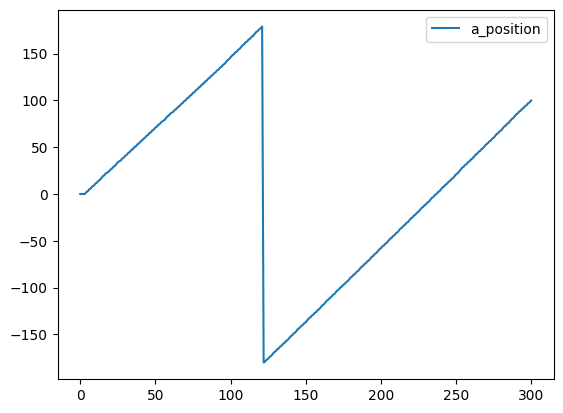

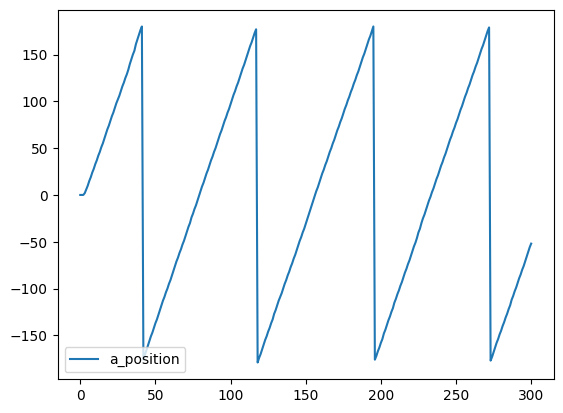

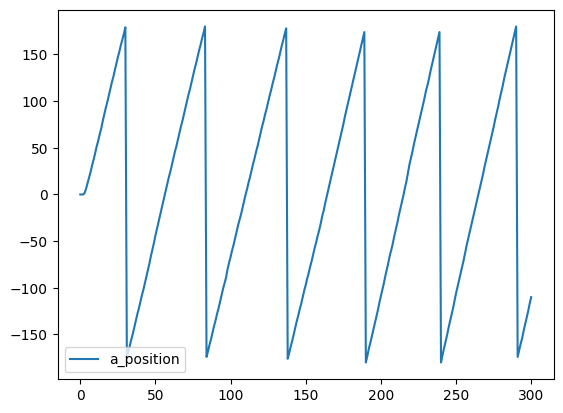

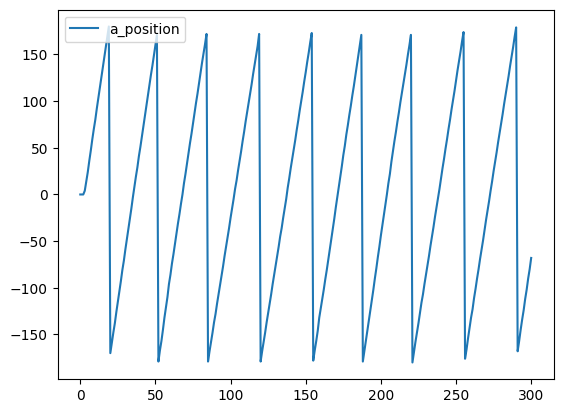

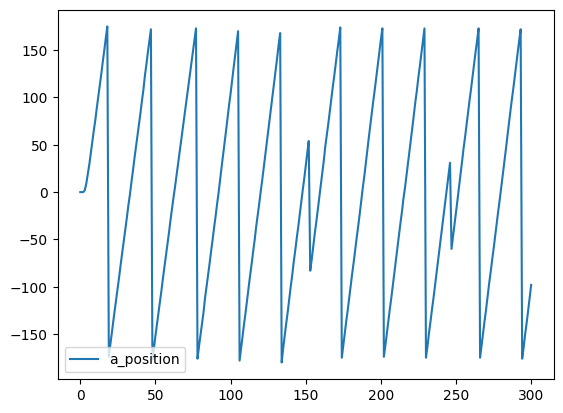

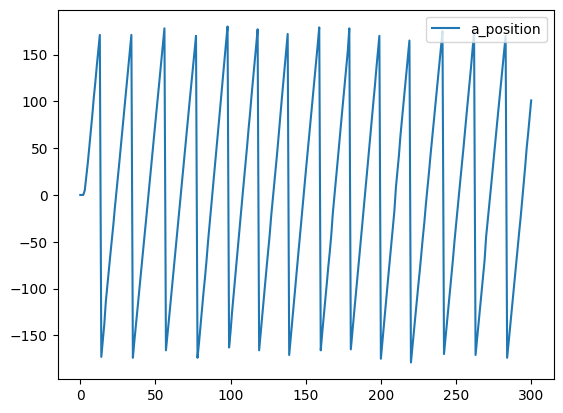

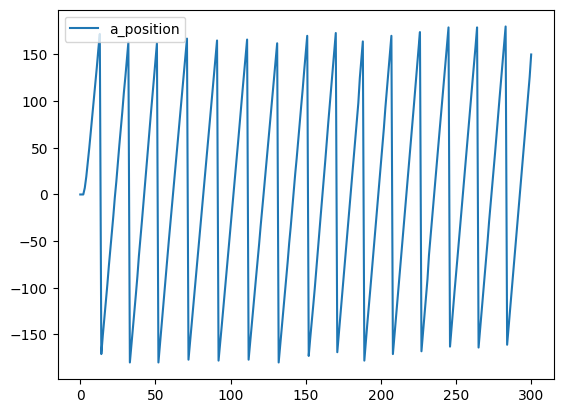

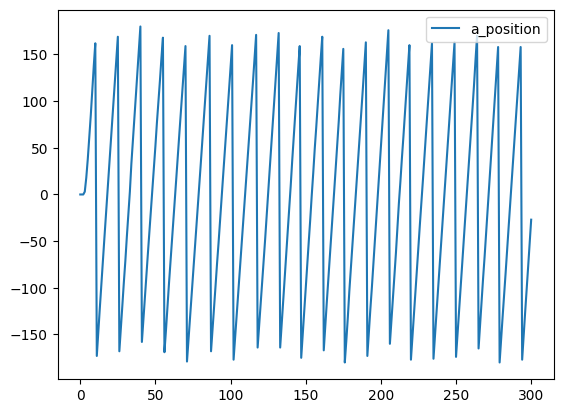

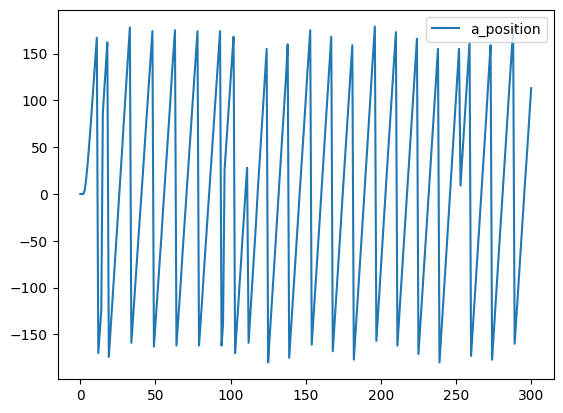

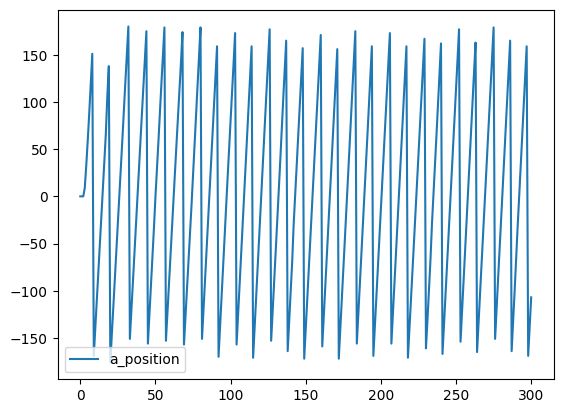

In [10]:
file_index = '01'
df9v10 = pd.read_csv('/home/uecadmin/researchScript/9v/param_ev3-speed-001_9v-10_20240407.tsv')
df9v20 = pd.read_csv('/home/uecadmin/researchScript/9v/param_ev3-speed-002_9v-20_1699022119.908378.tsv')
df9v30 = pd.read_csv('/home/uecadmin/researchScript/9v/param_ev3-speed-003_9v-30_20240407.tsv')
df9v40 = pd.read_csv('/home/uecadmin/researchScript/9v/param_ev3-speed-004_9v-40_1699022568.0509112.tsv')
df9v50 = pd.read_csv('/home/uecadmin/researchScript/9v/param_ev3-speed-005_9v-50_20240407.tsv')
df9v60 = pd.read_csv('/home/uecadmin/researchScript/9v/param_ev3-speed-006_9v_60_1699022648.5471888.tsv')
df9v70 = pd.read_csv('/home/uecadmin/researchScript/9v/param_ev3-speed-007_9v-70_20240407.tsv')
df9v80 = pd.read_csv('/home/uecadmin/researchScript/9v/param_ev3-speed-008_9v-80_1699022722.5847313.tsv')
df9v90 = pd.read_csv('/home/uecadmin/researchScript/9v/param_ev3-speed-009_9v-90_20240407.tsv')
df9v100 = pd.read_csv('/home/uecadmin/researchScript/9v/param_ev3-speed_010_9v-100_1699022784.8575094.tsv')
df9v10.plot(y='a_position')
df9v20.plot(y='a_position')
df9v30.plot(y='a_position')
df9v40.plot(y='a_position')
df9v50.plot(y='a_position')
df9v60.plot(y='a_position')
df9v70.plot(y='a_position')
df9v80.plot(y='a_position')
df9v90.plot(y='a_position')
df9v100.plot(y='a_position')
df9v10_2 = calc_dps(df9v10)
df9v20_2 = calc_dps(df9v20)
df9v30_2 = calc_dps(df9v30)
df9v40_2 = calc_dps(df9v40)
df9v50_2 = calc_dps(df9v50)
df9v60_2 = calc_dps(df9v60)
df9v70_2 = calc_dps(df9v70)
df9v80_2 = calc_dps(df9v80)
df9v90_2 = calc_dps(df9v90)
df9v100_2 = calc_dps(df9v100)

In [11]:
# https://atatat.hatenablog.com/entry/data_proc_python4
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.buttord.html
time = 6.727645635604856
samplerate = 44.59212274979287
fp = 5.8 # 通過域端周波数[Hz]：指定した周波数以下は減衰を受けない
fs = 5.9# 阻止域端周波数[Hz]：指定した周波数以上は減衰を受ける
gpass = 28 # 通過域端最大損失[dB]
gstop = 28.1 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate

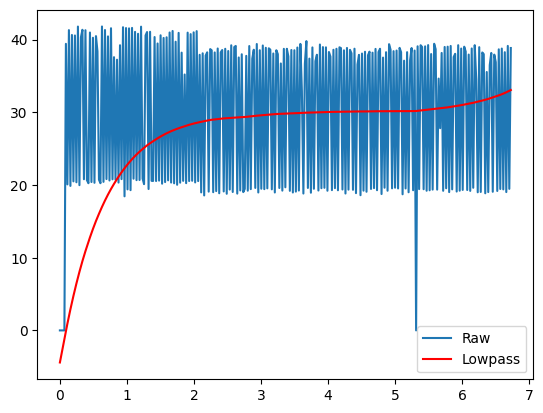

In [12]:
a_df_int = df9v10_2['dps_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v10_2['dps_a_filterd'] = data_lofilt

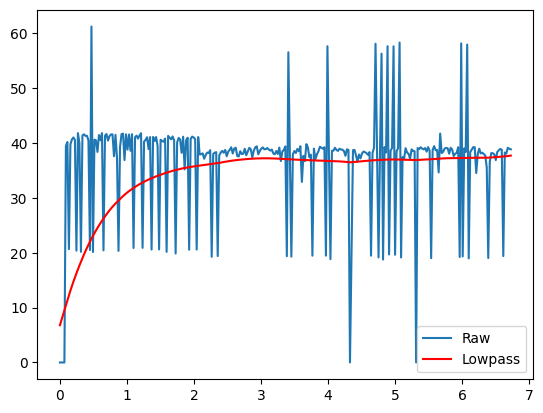

In [13]:
a_df_int = df9v10_2['dps_b'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v10_2['dps_b_filterd'] = data_lofilt

In [14]:
### https://atatat.hatenablog.com/entry/data_proc_python4
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.buttord.html
time = 6.727645635604856
samplerate = 44.59212274979287
fp = 5.8 # 通過域端周波数[Hz]：指定した周波数以下は減衰を受けない
fs = 5.9# 阻止域端周波数[Hz]：指定した周波数以上は減衰を受ける
gpass = 28 # 通過域端最大損失[dB]
gstop = 28.1 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate

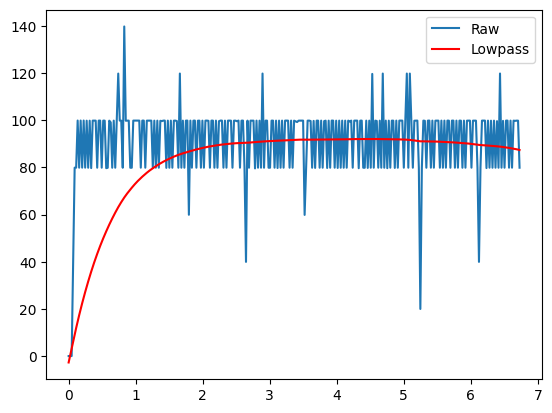

In [15]:
a_df_int = df9v20_2['dps_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v20_2['dps_a_filterd'] = data_lofilt

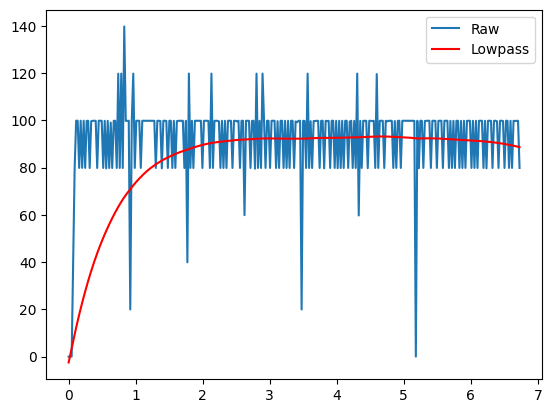

In [16]:
a_df_int = df9v20_2['dps_b'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v20_2['dps_b_filterd'] = data_lofilt

In [17]:
fp = 5.8 # 通過域端周波数[Hz]：指定した周波数以下は減衰を受けない
fs = 5.9# 阻止域端周波数[Hz]：指定した周波数以上は減衰を受ける
gpass = 33 # 通過域端最大損失[dB]
gstop = 33.1 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate

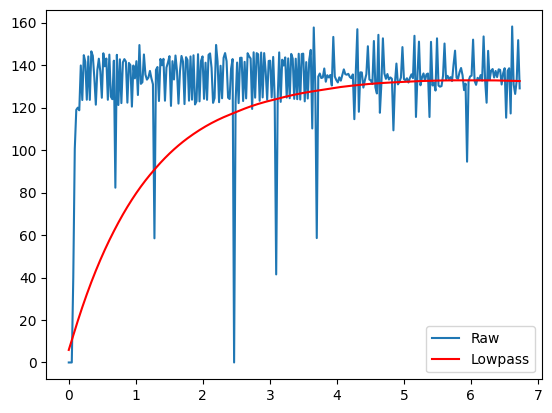

In [18]:
a_df_int = df9v30_2['dps_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v30_2['dps_a_filterd'] = data_lofilt

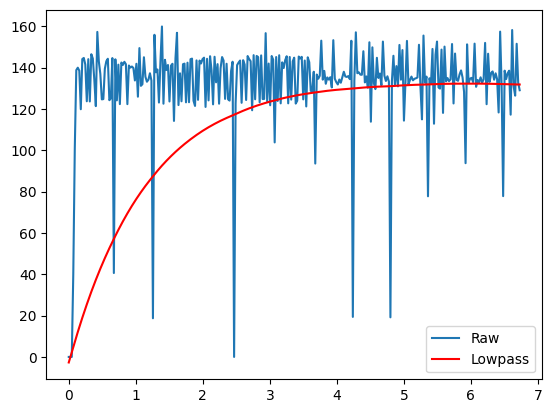

In [19]:
a_df_int = df9v30_2['dps_b'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v30_2['dps_b_filterd'] = data_lofilt

In [20]:
fp = 5.8 # 通過域端周波数[Hz]：指定した周波数以下は減衰を受けない
fs = 5.9# 阻止域端周波数[Hz]：指定した周波数以上は減衰を受ける
gpass = 33 # 通過域端最大損失[dB]
gstop = 33.1 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate

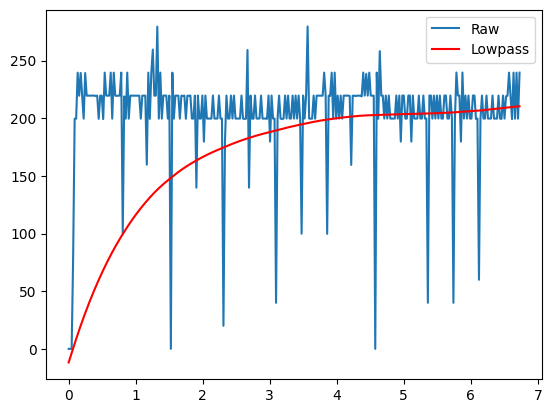

In [21]:
a_df_int = df9v40_2['dps_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v40_2['dps_a_filterd'] = data_lofilt

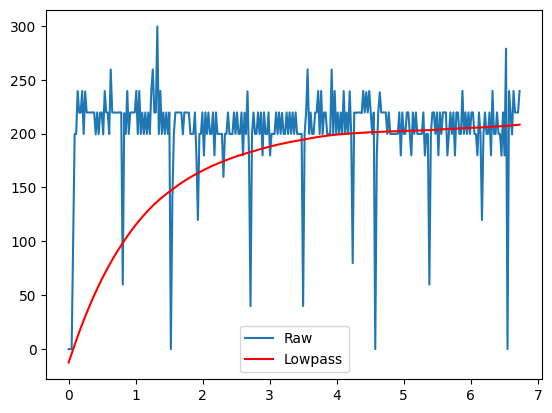

In [22]:
a_df_int = df9v40_2['dps_b'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v40_2['dps_b_filterd'] = data_lofilt

In [23]:
fp = 5.8 # 通過域端周波数[Hz]：指定した周波数以下は減衰を受けない
fs = 5.9# 阻止域端周波数[Hz]：指定した周波数以上は減衰を受ける
gpass = 33 # 通過域端最大損失[dB]
gstop = 33.1 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate

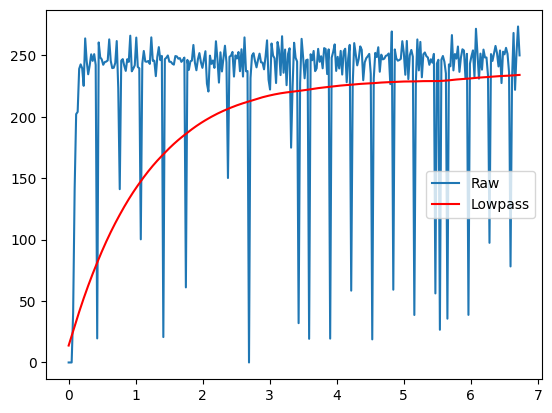

In [24]:
a_df_int = df9v50_2['dps_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v50_2['dps_a_filterd'] = data_lofilt

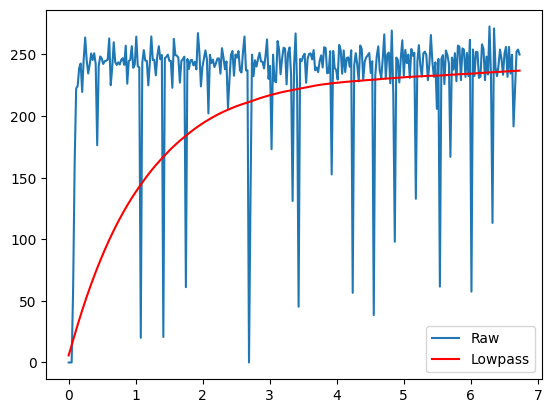

In [25]:
a_df_int = df9v50_2['dps_b'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v50_2['dps_b_filterd'] = data_lofilt

In [26]:
fp = 5.8 # 通過域端周波数[Hz]：指定した周波数以下は減衰を受けない
fs = 5.9# 阻止域端周波数[Hz]：指定した周波数以上は減衰を受ける
gpass = 33 # 通過域端最大損失[dB]
gstop = 33.1 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate

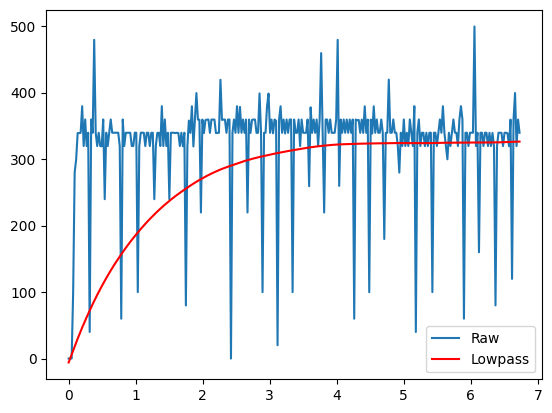

In [27]:
a_df_int = df9v60_2['dps_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v60_2['dps_a_filterd'] = data_lofilt

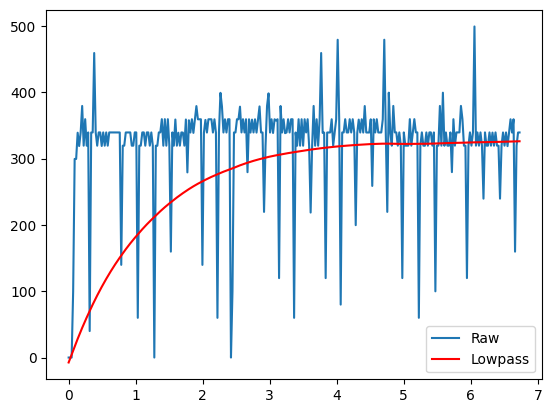

In [28]:
a_df_int = df9v60_2['dps_b'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v60_2['dps_b_filterd'] = data_lofilt

In [29]:
fp = 5.8 # 通過域端周波数[Hz]：指定した周波数以下は減衰を受けない
fs = 5.9# 阻止域端周波数[Hz]：指定した周波数以上は減衰を受ける
gpass = 33 # 通過域端最大損失[dB]
gstop = 33.1 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate

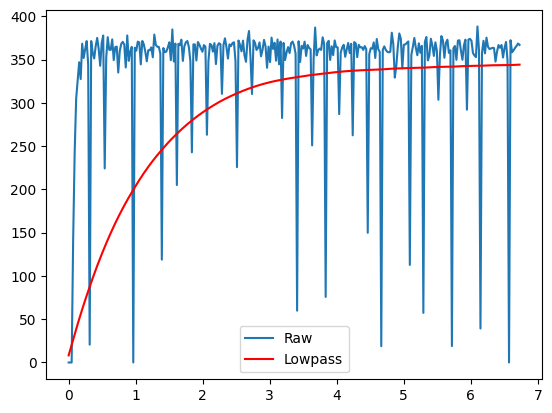

In [30]:
a_df_int = df9v70_2['dps_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v70_2['dps_a_filterd'] = data_lofilt

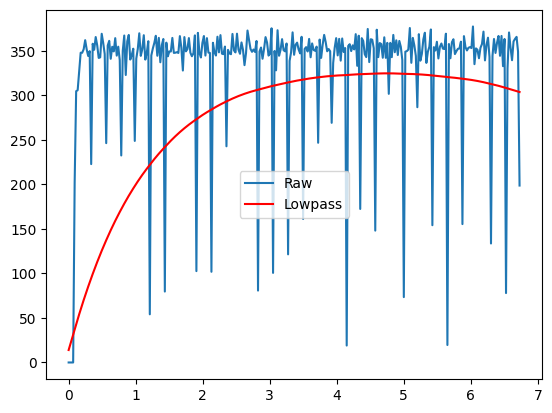

In [31]:
a_df_int = df9v70_2['dps_b'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v70_2['dps_b_filterd'] = data_lofilt

In [32]:
fp = 5.8 # 通過域端周波数[Hz]：指定した周波数以下は減衰を受けない
fs = 5.9# 阻止域端周波数[Hz]：指定した周波数以上は減衰を受ける
gpass = 33 # 通過域端最大損失[dB]
gstop = 33.1 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate

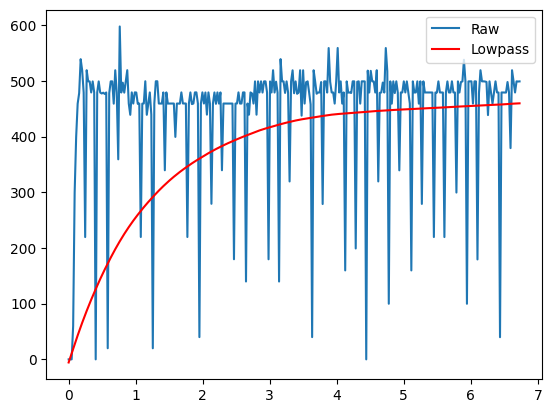

In [33]:
a_df_int = df9v80_2['dps_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v80_2['dps_a_filterd'] = data_lofilt

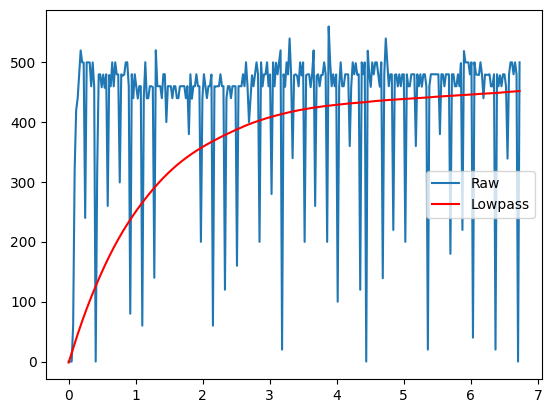

In [34]:
a_df_int = df9v80_2['dps_b'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v80_2['dps_b_filterd'] = data_lofilt

In [35]:
fp = 5.8 # 通過域端周波数[Hz]：指定した周波数以下は減衰を受けない
fs = 5.9# 阻止域端周波数[Hz]：指定した周波数以上は減衰を受ける
gpass = 33 # 通過域端最大損失[dB]
gstop = 33.1 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate

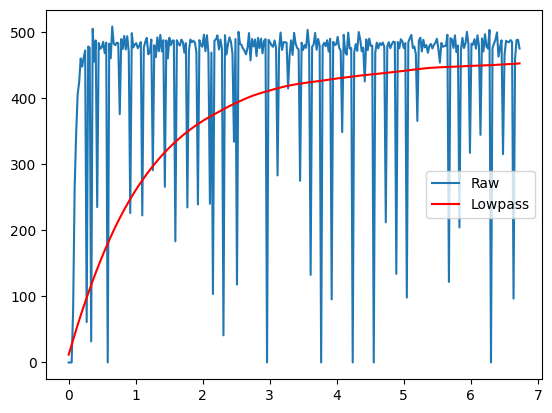

In [36]:
a_df_int = df9v90_2['dps_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v90_2['dps_a_filterd'] = data_lofilt

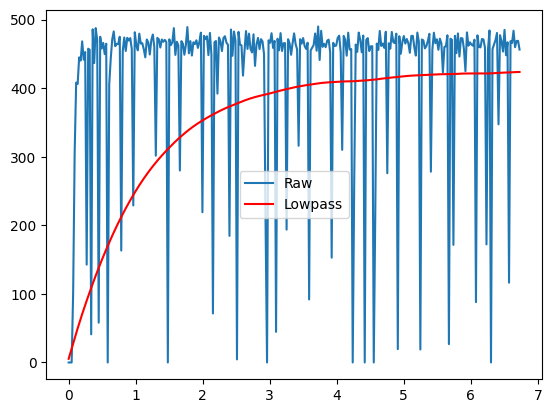

In [37]:
a_df_int = df9v90_2['dps_b'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v90_2['dps_b_filterd'] = data_lofilt

In [38]:
fp = 5.8 # 通過域端周波数[Hz]：指定した周波数以下は減衰を受けない
fs = 5.9# 阻止域端周波数[Hz]：指定した周波数以上は減衰を受ける
gpass = 33 # 通過域端最大損失[dB]
gstop = 33.1 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate

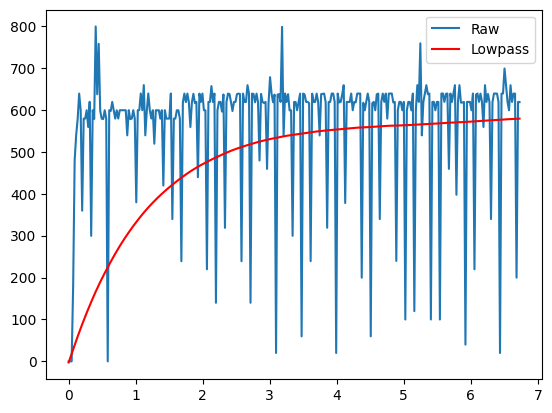

In [39]:
a_df_int = df9v100_2['dps_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v100_2['dps_a_filterd'] = data_lofilt

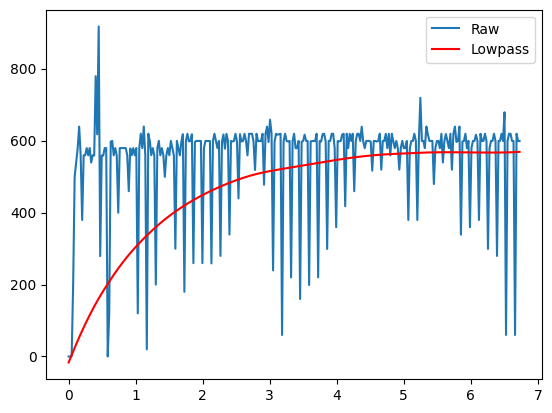

In [40]:
a_df_int = df9v100_2['dps_b'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v100_2['dps_b_filterd'] = data_lofilt

## 実験結果とシミュレーションの比較

### pwm_value = 10/0.9[v]

In [41]:
max_dps_a = df9v10_2['dps_a_filterd'].max()
th_a = max_dps_a * 0.632
tau_a = 0
max_dps_b = df9v10_2['dps_b_filterd'].max()
th_b = max_dps_b * 0.632
tau_b = 0
for index, row in df9v10_2.iterrows():
    if row['dps_a_filterd'] > th_a and tau_a == 0:
        tau_a = row['time']
    if row['dps_b_filterd'] > th_b and tau_b == 0:
        tau_b = row['time']
print(max_dps_a)
print(th_a)
print(tau_a)

33.070217073772405
20.90037719062416
1.9723711013793936



      100
----------------
s^2 + 17 s + 100



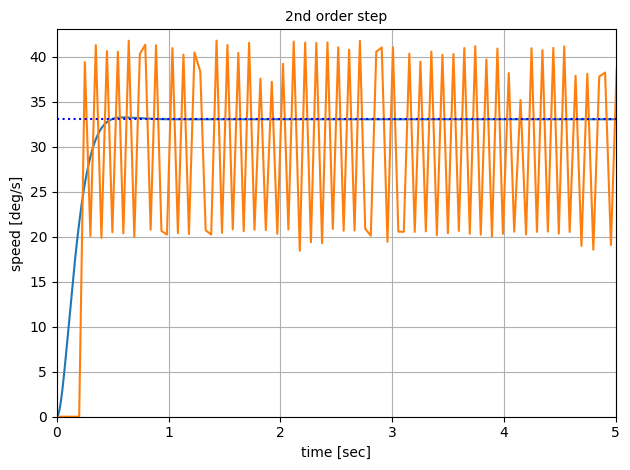

In [42]:
zeta = 0.85
omega_n = 10
z_c = max_dps_a
max_dps_a9v10 = max_dps_a
Kp = 1

x_max = 5
y_max = max_dps_a + 10
steps = 10000

# 伝達関数モデル作成
G2nd = tf_2nd_order(zeta, omega_n)

# 伝達関数モデル出力
print(G2nd)

# ステップ応答
t = np.linspace(0, x_max, steps)
(output, t) = matlab.step(G2nd, t)

#plot_line(output, t, z_c, x_max, y_max)
plot_line_over_experimental_data(output, t, z_c, x_max, y_max, df9v10_2['time'].values, df9v10_2['dps_a'].values)

### pwm_value = 20/1.8[v]

In [43]:
max_dps_a = df9v20_2['dps_a_filterd'].max()
th_a = max_dps_a * 0.632
tau_a = 0
max_dps_b = df9v20_2['dps_b_filterd'].max()
th_b = max_dps_b * 0.632
tau_b = 0
for index, row in df9v20_2.iterrows():
    if row['dps_a_filterd'] > th_a and tau_a == 0:
        tau_a = row['time']
    if row['dps_b_filterd'] > th_b and tau_b == 0:
        tau_b = row['time']
print(max_dps_a)
print(th_a)
print(tau_a)

92.02021809572756
58.15677783649981
1.460763931274413



      100
----------------
s^2 + 17 s + 100



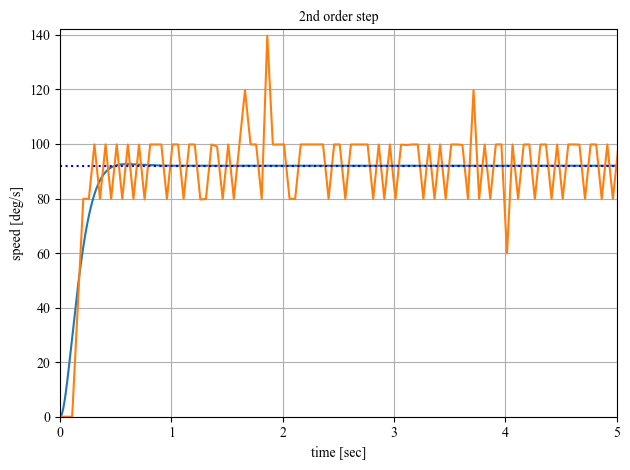

In [44]:
zeta = 0.85
omega_n = 10
z_c = max_dps_a
max_dps_a9v20 = max_dps_a
Kp = 1

x_max = 5
y_max = max_dps_a + 50
steps = 10000

# 伝達関数モデル作成
G2nd = tf_2nd_order(zeta, omega_n)

# 伝達関数モデル出力
print(G2nd)

# ステップ応答
t = np.linspace(0, x_max, steps)
(output, t) = matlab.step(G2nd, t)

#plot_line(output, t, z_c, x_max, y_max)
plot_line_over_experimental_data(output, t, z_c, x_max, y_max, df9v20_2['time'].values, df9v20_2['dps_a'].values)

In [45]:
(a_max, t_peak) = get_peak(z_c * output, t)
print(a_max - z_c)
print(t_peak)
(a_m, b_m) = calc_param_ab((a_max - z_c), t_peak, Kp, z_c)
print("a_m : " + str(a_m))
print("b_m : " + str(b_m))

0.5785856707479695
0.5965596559655966
omega_nc : 9.996882933339949
zeta_c : 0.8500000804901128
a_m : 16.99470259597838
b_m : 99.93766838290354


### pwm_value = 30/2.7[v]

In [46]:
max_dps_a = df9v30_2['dps_a_filterd'].max()
th_a = max_dps_a * 0.632
tau_a = 0
max_dps_b = df9v30_2['dps_b_filterd'].max()
th_b = max_dps_b * 0.632
tau_b = 0
for index, row in df9v30_2.iterrows():
    if row['dps_a_filterd'] > th_a and tau_a == 0:
        tau_a = row['time']
    if row['dps_b_filterd'] > th_b and tau_b == 0:
        tau_b = row['time']
print(max_dps_a)
print(th_a)
print(tau_a)

132.8649187399249
83.97062864363254
2.633064031600951



      100
----------------
s^2 + 17 s + 100



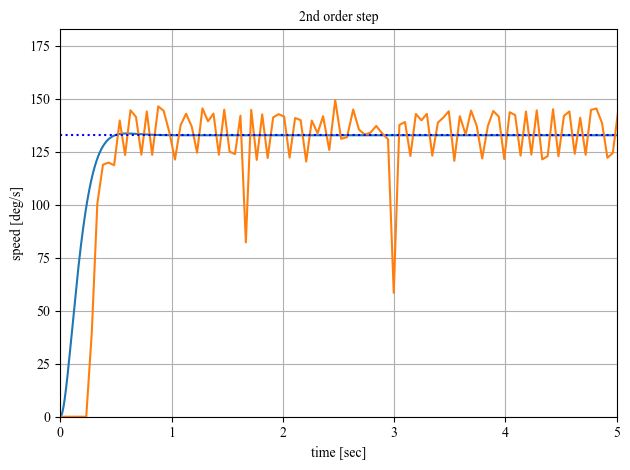

In [47]:
zeta = 0.85
omega_n = 10
z_c = max_dps_a
max_dps_a9v30 = max_dps_a
Kp = 1

x_max = 5
y_max = max_dps_a + 50
steps = 10000

# 伝達関数モデル作成
G2nd = tf_2nd_order(zeta, omega_n)

# 伝達関数モデル出力
print(G2nd)

# ステップ応答
t = np.linspace(0, x_max, steps)
(output, t) = matlab.step(G2nd, t)

plot_line_over_experimental_data(output, t, z_c, x_max, y_max, df9v30_2['time'].values, df9v30_2['dps_a'].values)

In [48]:
(a_max, t_peak) = get_peak(z_c * output, t)
print(a_max - z_c)
print(t_peak)
(a_m, b_m) = calc_param_ab((a_max - z_c), t_peak, Kp, z_c)
print("a_m : " + str(a_m))
print("b_m : " + str(b_m))

0.8354005208729518
0.5965596559655966
omega_nc : 9.996882933339958
zeta_c : 0.8500000804901129
a_m : 16.9947025959784
b_m : 99.93766838290371


### pwm_value = 40/3.6[v]

In [49]:
max_dps_a = df9v40_2['dps_a_filterd'].max()
th_a = max_dps_a * 0.632
tau_a = 0
max_dps_b = df9v40_2['dps_b_filterd'].max()
th_b = max_dps_b * 0.632
tau_b = 0
for index, row in df9v40_2.iterrows():
    if row['dps_a_filterd'] > th_a and tau_a == 0:
        tau_a = row['time']
    if row['dps_b_filterd'] > th_b and tau_b == 0:
        tau_b = row['time']
print(max_dps_a)
print(th_a)
print(tau_a)

210.34968070672434
132.9409982066498
2.813954830169677



      100
----------------
s^2 + 17 s + 100



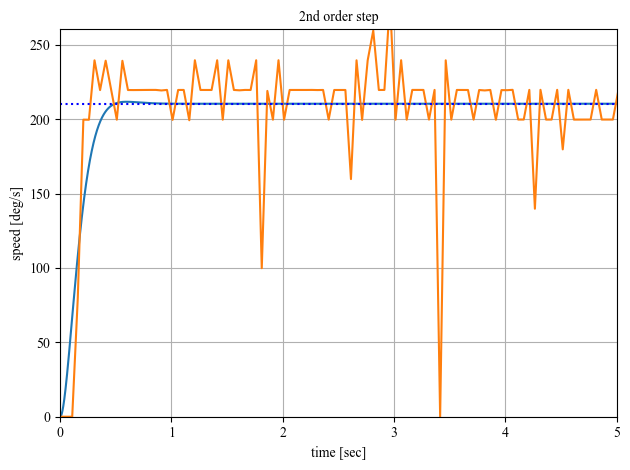

In [50]:
zeta = 0.85
omega_n = 10
z_c = max_dps_a
max_dps_a9v40 = max_dps_a
Kp = 1

x_max = 5
y_max = max_dps_a + 50
steps = 10000

# 伝達関数モデル作成
G2nd = tf_2nd_order(zeta, omega_n)

# 伝達関数モデル出力
print(G2nd)

# ステップ応答
t = np.linspace(0, x_max, steps)
(output, t) = matlab.step(G2nd, t)

plot_line_over_experimental_data(output, t, z_c, x_max, y_max, df9v40_2['time'].values, df9v40_2['dps_a'].values)

In [51]:
(a_max, t_peak) = get_peak(z_c * output, t)
print(a_max - z_c)
print(t_peak)
(a_m, b_m) = calc_param_ab((a_max - z_c), t_peak, Kp, z_c)
print("a_m : " + str(a_m))
print("b_m : " + str(b_m))

1.322593160741178
0.5965596559655966
omega_nc : 9.996882933339956
zeta_c : 0.8500000804901127
a_m : 16.994702595978392
b_m : 99.93766838290368


### pwm_value = 50/4.5[v]

In [52]:
max_dps_a = df9v50_2['dps_a_filterd'].max()
th_a = max_dps_a * 0.632
tau_a = 0
max_dps_b = df9v50_2['dps_b_filterd'].max()
th_b = max_dps_b * 0.632
tau_b = 0
for index, row in df9v50_2.iterrows():
    if row['dps_a_filterd'] > th_a and tau_a == 0:
        tau_a = row['time']
    if row['dps_b_filterd'] > th_b and tau_b == 0:
        tau_b = row['time']
print(max_dps_a)
print(th_a)
print(tau_a)

234.0736228330503
147.9345296304878
2.5354173183441153



      100
----------------
s^2 + 17 s + 100



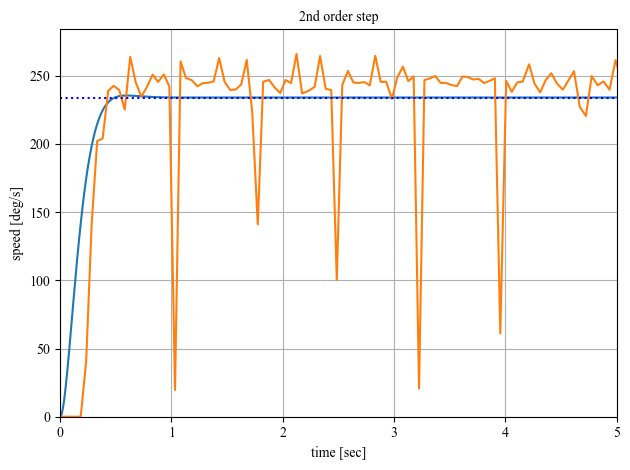

In [53]:
zeta = 0.85
omega_n = 10
z_c = max_dps_a
max_dps_a9v50 = max_dps_a
Kp = 1

x_max = 5
y_max = max_dps_a + 50
steps = 10000

# 伝達関数モデル作成
G2nd = tf_2nd_order(zeta, omega_n)

# 伝達関数モデル出力
print(G2nd)

# ステップ応答
t = np.linspace(0, x_max, steps)
(output, t) = matlab.step(G2nd, t)

plot_line_over_experimental_data(output, t, z_c, x_max, y_max, df9v50_2['time'].values, df9v50_2['dps_a'].values)

In [54]:
(a_max, t_peak) = get_peak(z_c * output, t)
print(a_max - z_c)
print(t_peak)
(a_m, b_m) = calc_param_ab((a_max - z_c), t_peak, Kp, z_c)
print("a_m : " + str(a_m))
print("b_m : " + str(b_m))

1.4717596510190845
0.5965596559655966
omega_nc : 9.996882933339945
zeta_c : 0.8500000804901126
a_m : 16.99470259597837
b_m : 99.93766838290347


### pwm_value = 60/5.4[v]

In [55]:
max_dps_a = df9v60_2['dps_a_filterd'].max()
th_a = max_dps_a * 0.632
tau_a = 0
max_dps_b = df9v60_2['dps_b_filterd'].max()
th_b = max_dps_b * 0.632
tau_b = 0
for index, row in df9v60_2.iterrows():
    if row['dps_a_filterd'] > th_a and tau_a == 0:
        tau_a = row['time']
    if row['dps_b_filterd'] > th_b and tau_b == 0:
        tau_b = row['time']
print(max_dps_a)
print(th_a)
print(tau_a)

326.2105707573611
206.1650807186522
2.661943435668944



      100
----------------
s^2 + 17 s + 100



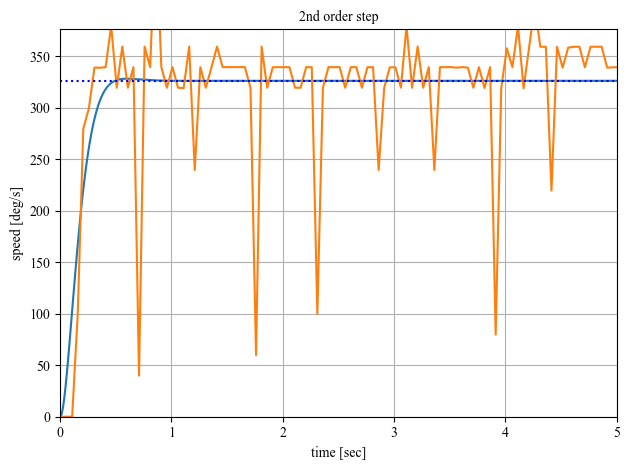

In [56]:
zeta = 0.85
omega_n = 10
z_c = max_dps_a
max_dps_a9v60 = max_dps_a
Kp = 1

x_max = 5
y_max = max_dps_a + 50
steps = 10000

# 伝達関数モデル作成
G2nd = tf_2nd_order(zeta, omega_n)

# 伝達関数モデル出力
print(G2nd)

# ステップ応答
t = np.linspace(0, x_max, steps)
(output, t) = matlab.step(G2nd, t)

plot_line_over_experimental_data(output, t, z_c, x_max, y_max, df9v60_2['time'].values, df9v60_2['dps_a'].values)

In [57]:
(a_max, t_peak) = get_peak(z_c * output, t)
print(a_max - z_c)
print(t_peak)
(a_m, b_m) = calc_param_ab((a_max - z_c), t_peak, Kp, z_c)
print("a_m : " + str(a_m))
print("b_m : " + str(b_m))

2.051079271409435
0.5965596559655966
omega_nc : 9.996882933339975
zeta_c : 0.8500000804901134
a_m : 16.994702595978442
b_m : 99.93766838290406


### pwm_value = 70/6.3[v]

In [58]:
max_dps_a = df9v70_2['dps_a_filterd'].max()
th_a = max_dps_a * 0.632
tau_a = 0
max_dps_b = df9v70_2['dps_b_filterd'].max()
th_b = max_dps_b * 0.632
tau_b = 0
for index, row in df9v70_2.iterrows():
    if row['dps_a_filterd'] > th_a and tau_a == 0:
        tau_a = row['time']
    if row['dps_b_filterd'] > th_b and tau_b == 0:
        tau_b = row['time']
print(max_dps_a)
print(th_a)
print(tau_a)

344.11626691746653
217.48148069183884
2.622779130935668



      100
----------------
s^2 + 17 s + 100



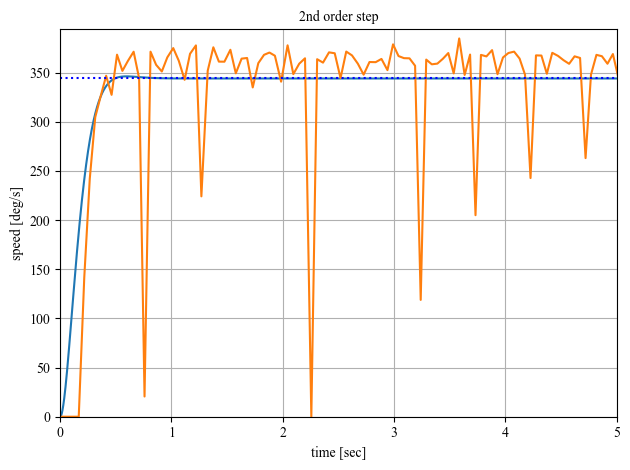

In [59]:
zeta = 0.85
omega_n = 10
z_c = max_dps_a
max_dps_a9v70 = max_dps_a
Kp = 1

x_max = 5
y_max = max_dps_a + 50
steps = 10000

# 伝達関数モデル作成
G2nd = tf_2nd_order(zeta, omega_n)

# 伝達関数モデル出力
print(G2nd)

# ステップ応答
t = np.linspace(0, x_max, steps)
(output, t) = matlab.step(G2nd, t)

plot_line_over_experimental_data(output, t, z_c, x_max, y_max, df9v70_2['time'].values, df9v70_2['dps_a'].values)

In [60]:
(a_max, t_peak) = get_peak(z_c * output, t)
print(a_max - z_c)
print(t_peak)
(a_m, b_m) = calc_param_ab((a_max - z_c), t_peak, Kp, z_c)
print("a_m : " + str(a_m))
print("b_m : " + str(b_m))

2.163662999609585
0.5965596559655966
omega_nc : 9.996882933339947
zeta_c : 0.8500000804901126
a_m : 16.994702595978374
b_m : 99.9376683829035


### pwm_value = 80/7.2[v]

In [61]:
max_dps_a = df9v80_2['dps_a_filterd'].max()
th_a = max_dps_a * 0.632
tau_a = 0
max_dps_b = df9v80_2['dps_b_filterd'].max()
th_b = max_dps_b * 0.632
tau_b = 0
for index, row in df9v80_2.iterrows():
    if row['dps_a_filterd'] > th_a and tau_a == 0:
        tau_a = row['time']
    if row['dps_b_filterd'] > th_b and tau_b == 0:
        tau_b = row['time']
print(max_dps_a)
print(th_a)
print(tau_a)

459.68520884366785
290.5210519891981
2.8144104480743404



      100
----------------
s^2 + 17 s + 100



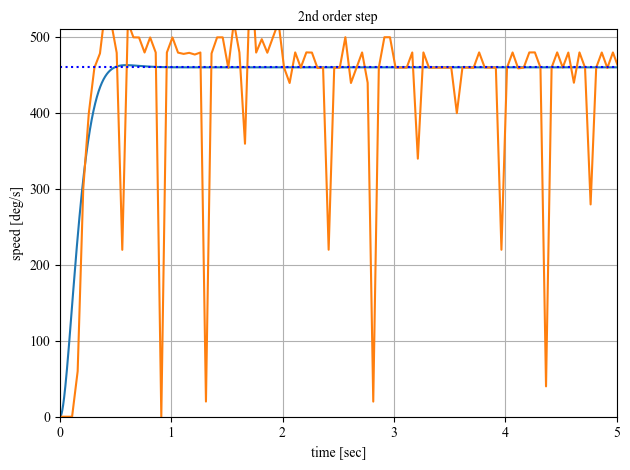

In [62]:
zeta = 0.85
omega_n = 10
z_c = max_dps_a
max_dps_a9v80 = max_dps_a
Kp = 1

x_max = 5
y_max = max_dps_a + 50
steps = 10000

# 伝達関数モデル作成
G2nd = tf_2nd_order(zeta, omega_n)

# 伝達関数モデル出力
print(G2nd)

# ステップ応答
t = np.linspace(0, x_max, steps)
(output, t) = matlab.step(G2nd, t)

plot_line_over_experimental_data(output, t, z_c, x_max, y_max, df9v80_2['time'].values, df9v80_2['dps_a'].values)

In [63]:
(a_max, t_peak) = get_peak(z_c * output, t)
print(a_max - z_c)
print(t_peak)
(a_m, b_m) = calc_param_ab((a_max - z_c), t_peak, Kp, z_c)
print("a_m : " + str(a_m))
print("b_m : " + str(b_m))

2.8903134593209643
0.5965596559655966
omega_nc : 9.996882933339961
zeta_c : 0.8500000804901129
a_m : 16.994702595978406
b_m : 99.93766838290378


### pwm_value = 90/8.1[v]

In [64]:
max_dps_a = df9v90_2['dps_a_filterd'].max()
th_a = max_dps_a * 0.632
tau_a = 0
max_dps_b = df9v90_2['dps_b_filterd'].max()
th_b = max_dps_b * 0.632
tau_b = 0
for index, row in df9v90_2.iterrows():
    if row['dps_a_filterd'] > th_a and tau_a == 0:
        tau_a = row['time']
    if row['dps_b_filterd'] > th_b and tau_b == 0:
        tau_b = row['time']
print(max_dps_a)
print(th_a)
print(tau_a)

452.8309472764844
286.1891586787381
3.989058256149291



      100
----------------
s^2 + 17 s + 100



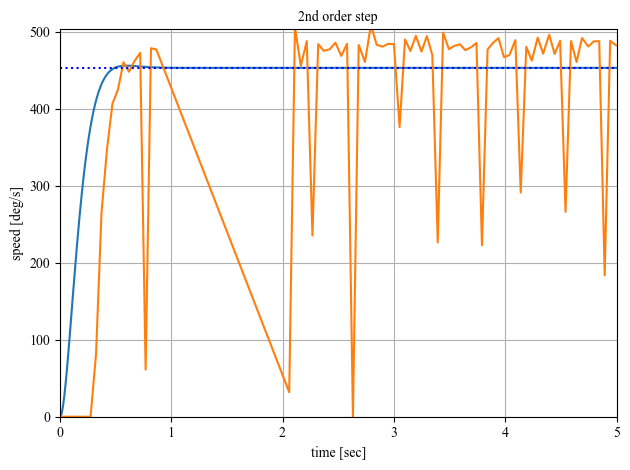

In [65]:
zeta = 0.85
omega_n = 10
z_c = max_dps_a
max_dps_a9v90 = max_dps_a
Kp = 1

x_max = 5
y_max = max_dps_a + 50
steps = 10000

# 伝達関数モデル作成
G2nd = tf_2nd_order(zeta, omega_n)

# 伝達関数モデル出力
print(G2nd)

# ステップ応答
t = np.linspace(0, x_max, steps)
(output, t) = matlab.step(G2nd, t)

plot_line_over_experimental_data(output, t, z_c, x_max, y_max, df9v90_2['time'].values, df9v90_2['dps_a'].values)

In [66]:
(a_max, t_peak) = get_peak(z_c * output, t)
print(a_max - z_c)
print(t_peak)
(a_m, b_m) = calc_param_ab((a_max - z_c), t_peak, Kp, z_c)
print("a_m : " + str(a_m))
print("b_m : " + str(b_m))

2.847216652897373
0.5965596559655966
omega_nc : 9.996882933339947
zeta_c : 0.8500000804901126
a_m : 16.994702595978374
b_m : 99.9376683829035


### pwm_value = 100/9.0[v]

In [67]:
max_dps_a = df9v100_2['dps_a_filterd'].max()
th_a = max_dps_a * 0.632
tau_a = 0
max_dps_b = df9v100_2['dps_b_filterd'].max()
th_b = max_dps_b * 0.632
tau_b = 0
for index, row in df9v100_2.iterrows():
    if row['dps_a_filterd'] > th_a and tau_a == 0:
        tau_a = row['time']
    if row['dps_b_filterd'] > th_b and tau_b == 0:
        tau_b = row['time']
print(max_dps_a)
print(th_a)
print(tau_a)

579.0142052605559
365.9369777246713
2.6625523567199694



      100
----------------
s^2 + 17 s + 100



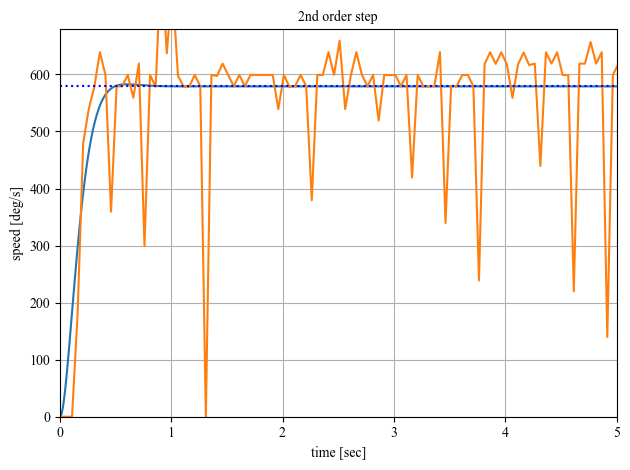

In [68]:
zeta = 0.85
omega_n = 10
z_c = max_dps_a
max_dps_a9v100 = max_dps_a
Kp = 1

x_max = 5
y_max = max_dps_a + 100
steps = 10000
9
# 伝達関数モデル作成
G2nd = tf_2nd_order(zeta, omega_n)

# 伝達関数モデル出力
print(G2nd)

# ステップ応答
t = np.linspace(0, x_max, steps)
(output, t) = matlab.step(G2nd, t)

plot_line_over_experimental_data(output, t, z_c, x_max, y_max, df9v100_2['time'].values, df9v100_2['dps_a'].values)

In [69]:
(a_max, t_peak) = get_peak(z_c * output, t)
print(a_max - z_c)
print(t_peak)
(a_m, b_m) = calc_param_ab((a_max - z_c), t_peak, Kp, z_c)
print("a_m : " + str(a_m))
print("b_m : " + str(b_m))

3.6406056109840392
0.5965596559655966
omega_nc : 9.99688293333995
zeta_c : 0.8500000804901128
a_m : 16.994702595978385
b_m : 99.93766838290357


## デューティー比と角速度の関係(9V)

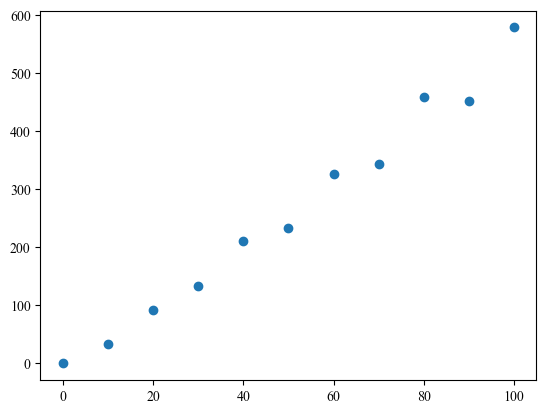

In [70]:
data = [
    [0, 0]
    ,[10, max_dps_a9v10]
    ,[20, max_dps_a9v20]
    ,[30, max_dps_a9v30]
    ,[40, max_dps_a9v40]
    ,[50, max_dps_a9v50]
    ,[60, max_dps_a9v60]
    ,[70, max_dps_a9v70]
    ,[80, max_dps_a9v80]
    ,[90, max_dps_a9v90]
    ,[100, max_dps_a9v100]
]

df = pd.DataFrame(data=data, columns=['duty-cycle', 'dps'])
x = df[['duty-cycle']]
y = df[['dps']]

plt.plot(x, y, 'o')
plt.show()

In [71]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(x, y)

LinearRegression()

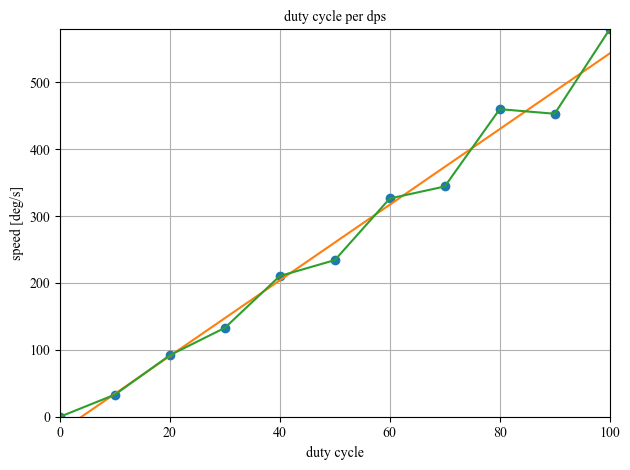

In [72]:
x_max=df['duty-cycle'].max()
y_max=df['dps'].max()

plt.plot(x, y, 'o')
plt.plot(x, model_lr.predict(x), linestyle="solid")
# 出力パラメータ
plt.plot(df['duty-cycle'], df['dps'])
plt.rcParams['font.family'] = 'Times New Roman' # 全体のフォント
plt.title('duty cycle per dps', fontsize=10)        # グラフタイトル
plt.xlabel('duty cycle', fontsize=10)           # x軸ラベル
plt.ylabel('speed [deg/s]', fontsize=10)               # y軸ラベル
plt.xlim([0, x_max])                              # x軸範囲
plt.ylim([0, y_max])                              # y軸範囲
plt.tick_params(labelsize = 10)                 # 軸ラベルの目盛りサイズ
plt.tight_layout()                              # ラベルがきれいに収まるよう表示
plt.grid()                                      # グリッド表示
plt.show()

In [73]:
print('モデル関数の回帰変数 w1: %.3f' %model_lr.coef_)
print('モデル関数の切片 w2: %.3f' %model_lr.intercept_)
print('y= %.3fx + %.3f' % (model_lr.coef_ , model_lr.intercept_))
print('決定係数 ： ', model_lr.score(x, y))

モデル関数の回帰変数 w1: 5.650
モデル関数の切片 w2: -22.136
y= 5.650x + -22.136
決定係数 ：  0.9840295289983724


/tmp/ipykernel_3496/3150842204.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('モデル関数の回帰変数 w1: %.3f' %model_lr.coef_)
/tmp/ipykernel_3496/3150842204.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('モデル関数の切片 w2: %.3f' %model_lr.intercept_)
/tmp/ipykernel_3496/3150842204.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('y= %.3fx + %.3f' % (model_lr.coef_ , model_lr.intercept_))


## モータ位置決め制御

## Export Data

In [74]:
t_delta = datetime.timedelta(hours=9)
JST = datetime.timezone(t_delta, 'JST')
now = datetime.datetime.now(JST)
d = now.strftime('%Y-%m-%d_%H:%M:%S')
print(d)

2024-04-14_18:41:23


In [75]:
#df2.to_csv('/home/uecadmin/researchScript/output_mufuka_test_pwm-0.2_002_' + file_index + '_' + str(d) + '.tsv', sep='\t', index=False)